In [1]:
# Remember to cite knotinfo
# https://knotinfo.math.indiana.edu/homelinks/cite_info.html
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
os.chdir('/Users/alexchandler/kr-calc/csv_files') #change to python script directory
knot_info = pd.read_csv('Knotinfo_data.csv', dtype='object')  

import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools


# import required module for iterating through directory
import os
import json
# assign directory
os.chdir('/Users/alexchandler/kr-calc') #change to python script directory
directory = 'data'
#we create a dictionary with keys: names of knots
                          #values: dictionaries (keys: nonzero gradings, values: homology dimensions)
homfly_data={}
# sort directory and then iterate over files in that directory, creating a dictionary for easier use
listing = os.listdir(directory)
listing.sort()
for filename in listing:
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f) as json_file:
            data = json.load(json_file)
            data_dict = {}
            for i in range(int(len(data)/2)):
                data_dict[tuple(data[2*i])]=data[2*i+1]
            homfly_data[filename[:-5]]=data_dict
            
#import functions from functions.py (contains all functions being called in this notebook)
os.chdir('/Users/alexchandler/kr-calc/python_scripts') #change to python script directory
from functions import *

#creates two groups: planar and nonplanar
planar_knots = [knot for knot in list(homfly_data.keys()) 
                    if planar_support_alt(homfly_data[knot])==1]
non_planar_knots = [knot for knot in list(homfly_data.keys()) 
                    if planar_support_alt(homfly_data[knot])>1]

#gathered all possible knot invariants from knotinfo (saved as 'all_knotinfo.csv')
#turning it into a pandas dataframe
os.chdir('/Users/alexchandler/kr-calc/csv_files') #change to python script directory
all_knot_info = pd.read_csv('all_knotinfo.csv') 

#adding data to set of all invariants (on knots for which we know homology)
#if we don't have the homology for the knot, we set it to 0 and then get rid of all rows with 0 values
all_knot_info['Planar Support']=compute_planar_support_vect(all_knot_info['Name'])
all_knot_info['Delta Values']=delta_vect(all_knot_info['Name'])
all_knot_info['Size of Homology']=size_of_homology_vect(all_knot_info['Name'])

#getting rid of rows with 0 values (where we don't know the homology)
all_mask = all_knot_info["Planar Support"]!=0
all_knot_info = all_knot_info[all_mask]

#adding parity
all_knot_info['Parity']=(all_knot_info['Name']).apply(check_parity)

#lets take a look
all_knot_info

,Name,Alternating,Two-Bridge Notation,Fibered,Crossing Number,Unknotting Number,Genus-3D,Crosscap Number,Bridge Index,Braid Index,...,Almost Alternating,Adequate,Montesinos Notation,Boundary Slopes,Pretzel Notation,Double Slice Genus,Planar Support,Delta Values,Size of Homology,Parity
0,3_1,Y,3/1,Y,3,1,1,1,2,2,...,N,Y,K(1/3),{0;6},P(-1;-1;-1),2,1,{2},3,1.0
1,4_1,Y,5/2,Y,4,1,1,2,2,3,...,N,Y,K(2/5),{-4;0;4},P(1;1;2),2,1,{0},5,0.0
2,5_1,Y,5/1,Y,5,2,2,1,2,2,...,N,Y,K(1/5),{0;10},P(-1;-1;-1;-1;-1),4,1,{4},5,1.0
3,5_2,Y,7/3,N,5,1,1,2,2,3,...,N,Y,K(3/7),{0;4;10},P(-1;-1;-3),2,1,{2},7,0.0
4,6_1,Y,9/7,N,6,1,1,2,2,4,...,N,Y,K(4/9),{-4;0;8},P(-1;-1;-4),1,1,{0},9,0.0
5,6_2,Y,11/4,Y,6,1,2,2,2,3,...,N,Y,K(4/11),{-4;0;2;8},P(1;2;3),2,1,{2},11,0.0
6,6_3,Y,13/5,Y,6,1,2,3,2,3,...,N,Y,K(5/13),{-6;-2;0;2;6},P(2;1;-3;1),2,1,{0},13,0.0
7,7_1,Y,7/1,Y,7,3,3,1,2,2,...,N,Y,K(1/7),{0;14},P(-1;-1;-1;-1;-1;-1;-1),6,1,{6},7,1.0
8,7_2,Y,11/5,N,7,1,1,2,2,4,...,N,Y,K(5/11),{0;4;14},P(-5;-1;-1),2,1,{2},11,0.0
9,7_3,Y,13/9,N,7,2,2,2,2,3,...,N,Y,K(4/13),{0;8;14},P(1;1;1;4),4,1,{4},13,0.0


In [2]:
#removes extra 0s a reformats to be consistent with kr-calc format i.e. '03_001' becomes '3_1'
def reformat(string):
    while string[0]=='0':
        string=string[1:]
    if '_' in string:
        string=string.split('_')
    else:
        string = [string[0:3],string[3:]]
    string0=string[0]
    string1=string[1]
    while string0[0]=='0':
        string0=string0[1:]
    while string1[0]=='0':
        string1=string1[1:]
    return string0+'_'+string1

#gets homology data from the lewark sl3 data file
def obtain_homology(sl3_data):
    i=sl3_data.find('Rational reduced homology: ') + len('Rational reduced homology: ')
    j=sl3_data.find('\nTotal rank')
    return sl3_data[i:j]

#creates listing of directory containing sl3 data
sl3_data={}
os.chdir('/Users/alexchandler/kr-calc') #change to python script directory
directory = 'reduced_sl3'
listing = os.listdir(directory)
listing.sort()

#example making sure we are reading the files correctly
filename=listing[0]
#open text file in read mode
text_file = open("reduced_sl3/"+filename, "r")
#read whole file to a string
data = text_file.read()
print(data)
print(filename)
obtain_homology(data)

Girth-optimised link diagram (modified pd notation) [[1,4,2,5],[3,6,4,1],[5,2,6,3]].
Girth: 4.
Done. Result:
Rational reduced homology: t^-3(q^12) + t^-2(q^8) + (q^4)
Total rank: 3.
The homology is torsion-free.
Run time in seconds: 0
Memory consumption in megabytes: 7.9

03_001


't^-3(q^12) + t^-2(q^8) + (q^4)'

In [3]:
#load sl3 data from lewark dataset into a dictionary sl3_data
for i in range(len(listing)):
    filename = listing[i]
    #open text file in read mode
    text_file = open("reduced_sl3/"+filename, "r")
    #read whole file to a string
    data = text_file.read()
    #close file
    text_file.close()
    sl3_data[reformat(filename)]=obtain_homology(data)
    
sl3_data['3_1']

't^-3(q^12) + t^-2(q^8) + (q^4)'

In [4]:
def signature(knot):
    i=all_knot_info.index[all_knot_info['Name'] == knot].tolist()[0]
    return all_knot_info['Signature'][i]

RR.<q,t> = PolynomialRing(QQ)
KK = RR.fraction_field()
#reformats string from lewark dataset into a format that sage can read as a polynomial (fixing order of operations issues)
def sl3_link_homology(knot):
    #defining the ring where our polynomials live (requires sage)
    poly = sl3_data[knot]
    poly=poly.replace(' ','')
    numbers=['0','1','2','3','4','5','6','7','8','9']
    acceptables = ['+','-','*','(','^']
    variables=['q','t']
    while True:
        issuesvars = [i for i in range(len(poly)) if i>0 and (poly[i] in variables) 
                      and not (poly[i-1] in acceptables)]
        issuesnums = [i for i in range(len(poly)) if i>0 and (poly[i].isnumeric()) 
                      and not(poly[i-1].isnumeric()) and not (poly[i-1] in acceptables)]
        issues = issuesvars + issuesnums
        if len(issues)==0:
            break
        i = issues[0]
        poly1=poly[0:i]
        poly2=poly[i:]
        poly=poly1+'*'+poly2
    i=0
    while i<len(poly):
        if poly[i] in numbers and poly[i+1]=='(':
            poly=poly[0:i+1]+'*'+poly[i+1:]
        i+=1
    i=0
    while i<len(poly):
        if poly[i]=='t' and poly[i+1]=='(':
            poly=poly[0:i+1]+'*'+poly[i+1:]
        i+=1
    i=0
    while i<len(poly):
        if poly[i]=='q' and poly[i+1]=='(':
            poly=poly[0:i+1]+'*'+poly[i+1:]
        i+=1
    i=0
    while i<len(poly):
        if poly[i]=='^':
            poly=poly[0:i+1]+'('+poly[i+1:]
            j=i+2
            while poly[j] in (numbers+['-']):
                j+=1
            poly = poly[0:j]+')'+poly[j:]
        i+=1
    num = KK(poly).numerator().dict()
    den = list(KK(poly).denominator().dict().keys())[0]
    qq= den[0]
    tt= den[1]
    mod_num={}
    for key in list(num.keys()):
        mod_num[(key[0]-qq,key[1]-tt)]=num[key]
    return mod_num

#takes a knot notation like '10_10' as input and outputs a planar diagram for homology groups
def plot_sl3(knot,gridlines=True):  
    homology = sl3_link_homology(knot)
    gradings = homology.keys()
    #making markers as ranks of homology groups
    markers=[]
    for grading in gradings:
        markers.append(homology[grading])
    xs = [grading[1] for grading in gradings]
    ys = [grading[0] for grading in gradings]
    #configuring the plot
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    #ax[0].scatter(xs, ys, s=1, c="white")
    # change default range
    ax[0].set_xlim((min(xs)-1, max(xs)+1))
    ax[0].set_ylim((min(ys)-1, max(ys)+1))
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('q')
    # Minor ticks
    ax[0].set_xticks(np.arange(min(xs)-.5, max(xs)+1, 1), minor=True)
    ax[0].set_yticks(np.arange(min(ys)-.5, max(ys)+1, 1), minor=True)

    # Gridlines based on minor ticks
    if gridlines:
        ax[0].grid(which='minor', color='gray', linestyle='dotted', linewidth=1)
    
    #computing the signature
    base = list(gradings)[0]
    #setting the title
    ax[0].set(title='reduced sl_3 Homology of '+knot, 
              aspect=.5, xticks=range(min(xs)-1, max(xs)+2), yticks=range(min(ys), max(ys)+2))
    #setting xscale and yscale to be equal
    plt.gca().set_aspect(1, adjustable='box')
    #circling gradings containing d1 and dm1 homology

    #making colors depending on size of homology
    colors=[]
    for txt in markers:
        if txt%6==1:
            colors.append("black")
        elif txt%6==2:
            colors.append("blue")
        elif txt%6==3:
            colors.append("green")
        elif txt%6==4:
            colors.append("red")
        elif txt%6==5:
            colors.append("purple")
        elif txt%6==0:
            colors.append("orange")
    #drawing the ranks of homology groups over top of invisible dots
    for i, txt in enumerate(markers):
        text_kwargs = dict(ha='center', va='center', fontsize=20, color=colors[i])
        ax[0].text(xs[i], ys[i], txt, **text_kwargs)
        #ax[0].annotate(txt, xy=(xs[i], ys[i]),xytext=(xs[i]-0.3, ys[i]-0.4),fontsize=20, c=colors[i])
    #showing image of knot
    ax[1].set(title=knot, aspect=1, xticks=[], yticks=[])
    img = mpimg.imread('diagrams/'+knot+'.png')
    imgplot = ax[1].imshow(img)
    #plt.show()
    
def poincare_poly(knot,convention='NS'):
    homology = homfly_data[knot]
    R.<q,a,t>=PolynomialRing(QQ)
    K=R.fraction_field()
    poly=0
    if convention=='NS':
        for key in homology.keys():
            poly+= K(str(homology[key])+'*q^'+str(key[0])+'*a^'+str(key[1])+'*t^'+str(int((key[2]-key[1])/2)))
    elif convention=='DGR':
        homology=convert_homology_NS_DGR(homology)
        for key in homology.keys():
            poly+=K(str(homology[key])+'*q^'+str(key[0])+'*a^'+str(key[1])+'*t^'+str(key[2]))
    return poly
            
    

In [5]:
knot='3_1'
signature(knot)

-2

In [6]:
knot='3_1'
sl3_link_homology(knot)

{(12, -3): 1, (8, -2): 1, (4, 0): 1}

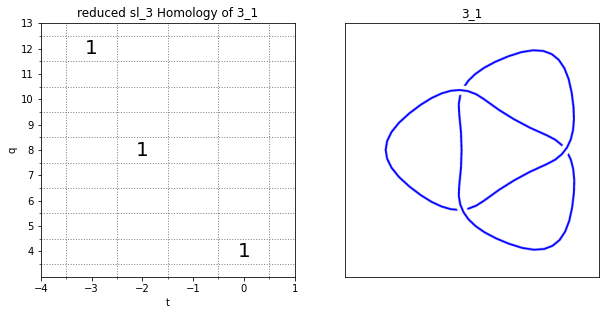

In [7]:
plot_sl3('3_1')

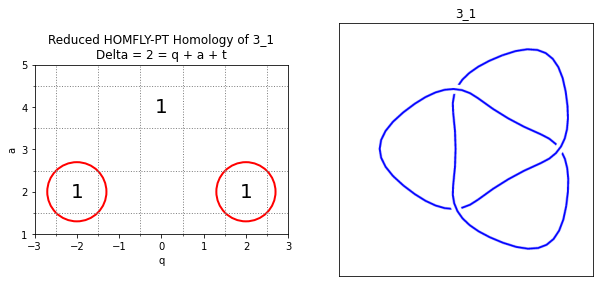

In [8]:
plot_homology_planar('3_1','NS')

d_1 and d_-1 homology only implemented for convention=='NS' and vars='qa'


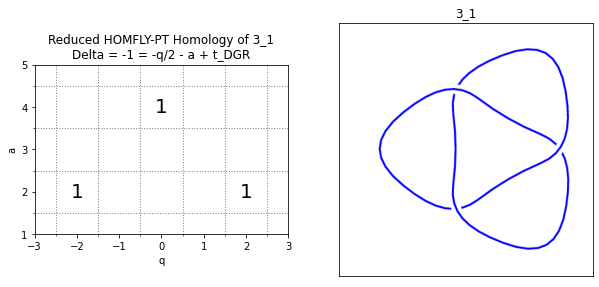

In [9]:
plot_homology_planar('3_1','DGR')

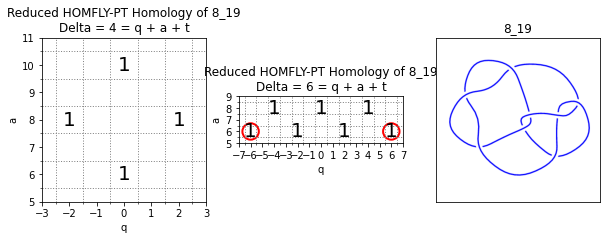

In [10]:
plot_homology_nonplanar('8_19','NS')

d_1 and d_-1 homology only implemented for vars="qa" and convention="NS"


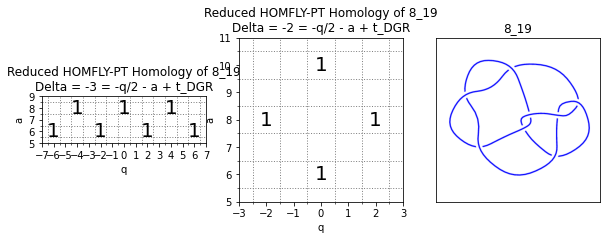

In [11]:
plot_homology_nonplanar('8_19','DGR')

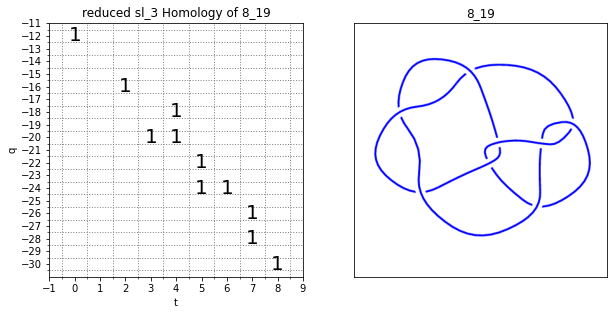

In [12]:
plot_sl3('8_19')

In [13]:
#this is how the sl3 homology data is stored
knot='10_10'
homology = sl3_link_homology(knot);homology

{(8, -3): 1,
 (6, -2): 2,
 (4, -1): 1,
 (4, -2): 1,
 (2, -1): 3,
 (0, 0): 5,
 (-2, 1): 3,
 (-2, 0): 1,
 (-4, 2): 1,
 (-4, 1): 4,
 (-6, 2): 5,
 (-8, 3): 4,
 (-8, 2): 1,
 (-10, 4): 1,
 (-10, 3): 2,
 (-12, 4): 4,
 (-14, 5): 2,
 (-16, 6): 1,
 (-16, 5): 1,
 (-18, 6): 1,
 (-20, 7): 1}

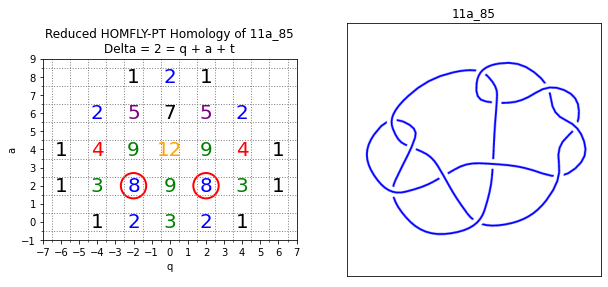

In [14]:
plot_homology_planar('11a_85')

In [15]:
#this computes the homfly polynomial of the trefoil from sage
B = BraidGroup(2)
#add in q so we can substitute z=q-1/q
R.<a,z,q> = LaurentPolynomialRing(QQ)
K = Knot(B([1,1,1]))
hpoly = K.homfly_polynomial(normalization='az')
hpoly.subs(z=q-1/q).subs(a=1/a)

-a^4 + a^2*q^2 + a^2*q^-2

In [16]:
#input is braid word e.g. [1,2,3,4,3,2,3] and braid group index e.g. 5
#the output is given in Nakagane and Sano conventions if convention = 'NS' and DGR for DGR
def homfly_polynomial(braid,n,convention='NS'):
    B = BraidGroup(n)
    #add in q so we can substitute z=q-1/q
    R.<a,z,q> = LaurentPolynomialRing(QQ)
    K = Knot(B(braid))
    hpoly = K.homfly_polynomial(normalization='az')
    if convention=='NS':
        return hpoly.subs(z=q-1/q).subs(a=1/a)
    elif convention=='DGR':
        return hpoly.subs(z=q-1/q)

In [17]:
poly = homfly_polynomial([-1,-1,-1],2)

In [18]:
poly==poly.subs(a=1/a)

False

In [19]:
show(poly)

a^-2*q^2 + a^-2*q^-2 - a^-4

In [20]:
show(poly.subs(a=1/a))

-a^4 + a^2*q^2 + a^2*q^-2

In [21]:
B = BraidGroup(2)
braid=[1,1,1]
K = Knot(B(braid))

In [22]:
homfly_data['3_1']

{(0, 4, -2): 1, (-2, 2, 2): 1, (2, 2, -2): 1}

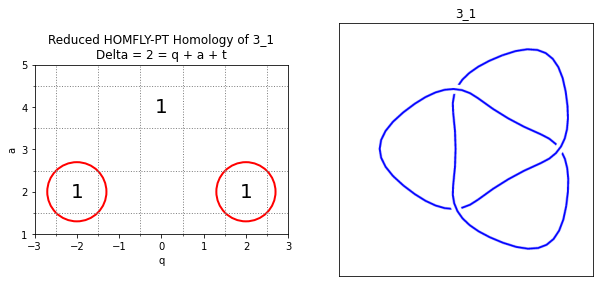

In [23]:
plot_homology_planar('3_1')

In [48]:
#recall ordering is (q,a,t)
#conventions can be 'NS', 'DGR', or 'L' (pick "L" to coincide with Lewark)
def homology_sl(N,knot,convention='DGR'):
    homology = homfly_data[knot]
    if N==2 and planar_support_alt(homfly_data[knot])==1:
        new_homology = {}
        for key in list(homology.keys()):
            q=key[0]
            a=key[1]
            t=key[2]
            t_dgr=int((a-t)/2)
            if (q+N*a,t_dgr) in new_homology.keys():
                new_homology[(q+N*a,t_dgr)]+=homology[key]
            else:
                new_homology[(q+N*a,t_dgr)]=homology[key]
    elif N==2 and planar_support_alt(homfly_data[knot])==2:
        print('not yet implemented for N=2 and delta=2')
    else:
        new_homology = {}
        for key in list(homology.keys()):
            q=key[0]
            a=key[1]
            t=key[2]
            t_dgr=int((a-t)/2)
            if (q+N*a,t_dgr) in new_homology.keys():
                new_homology[(q+N*a,t_dgr)]+=homology[key]
            else:
                new_homology[(q+N*a,t_dgr)]=homology[key]
    if convention=="L": # to get Lewark convention we switch t with -t
        new_new_homology = {}
        for key in list(new_homology.keys()):
            q=key[0]
            t=key[1]
            new_new_homology[(q,-t)]=new_homology[key]
        return new_new_homology
    elif convention=="Lbar": # to get Lewark convention we switch t with -t
        new_new_homology = {}
        for key in list(new_homology.keys()):
            q=key[0]
            t=key[1]
            new_new_homology[(-q,t)]=new_homology[key]
        return new_new_homology
    return new_homology

#takes a knot notation like '10_10' as input and outputs a planar diagram for homology groups
def plot_homology_sl(N,knot,convention='DGR',gridlines=True):  
    homology = homology_sl(N,knot,convention)
    
    gradings = homology.keys()
    #making markers as ranks of homology groups
    markers=[]
    for grading in gradings:
        markers.append(homology[grading])
    xs = [grading[1] for grading in gradings]
    ys = [grading[0] for grading in gradings]
    #configuring the plot
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    #ax[0].scatter(xs, ys, s=1, c="white")
    # change default range
    ax[0].set_xlim((min(xs)-1, max(xs)+1))
    ax[0].set_ylim((min(ys)-1, max(ys)+1))
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('q')
    # Minor ticks
    ax[0].set_xticks(np.arange(min(xs)-.5, max(xs)+1, 1), minor=True)
    ax[0].set_yticks(np.arange(min(ys)-.5, max(ys)+1, 1), minor=True)

    # Gridlines based on minor ticks
    if gridlines:
        ax[0].grid(which='minor', color='gray', linestyle='dotted', linewidth=1)
    
    #computing the signature
    base = list(gradings)[0]
    #setting the title
    ax[0].set(title='reduced sl_'+str(N)+' Homology of '+knot, 
              aspect=.5, xticks=range(min(xs)-1, max(xs)+2), yticks=range(min(ys), max(ys)+2))
    #setting xscale and yscale to be equal
    plt.gca().set_aspect(1, adjustable='box')
    #circling gradings containing d1 and dm1 homology

    #making colors depending on size of homology
    colors=[]
    for txt in markers:
        if txt%6==1:
            colors.append("black")
        elif txt%6==2:
            colors.append("blue")
        elif txt%6==3:
            colors.append("green")
        elif txt%6==4:
            colors.append("red")
        elif txt%6==5:
            colors.append("purple")
        elif txt%6==0:
            colors.append("orange")
    #drawing the ranks of homology groups over top of invisible dots
    for i, txt in enumerate(markers):
        text_kwargs = dict(ha='center', va='center', fontsize=20, color=colors[i])
        ax[0].text(xs[i], ys[i], txt, **text_kwargs)
        #ax[0].annotate(txt, xy=(xs[i], ys[i]),xytext=(xs[i]-0.3, ys[i]-0.4),fontsize=20, c=colors[i])
    #showing image of knot
    ax[1].set(title=knot, aspect=1, xticks=[], yticks=[])
    img = mpimg.imread('diagrams/'+knot+'.png')
    imgplot = ax[1].imshow(img)
    #plt.show()

In [49]:
knot='10_1'

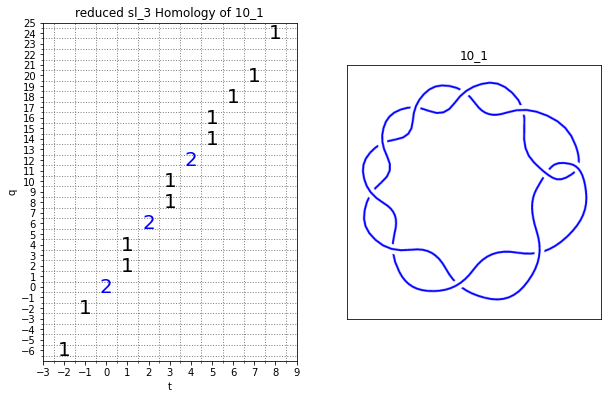

In [50]:
#with no 3rd argument we get 'DGR' convention
plot_homology_sl(3,knot)

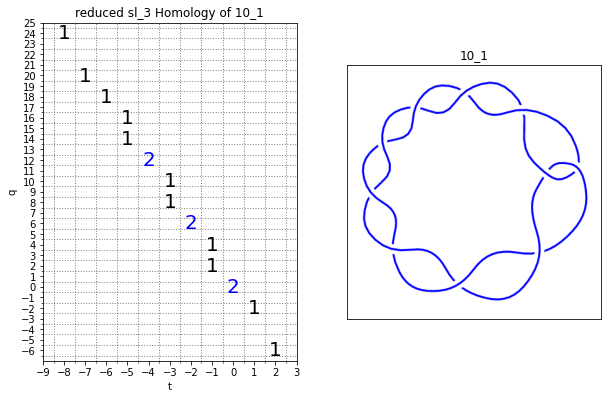

In [51]:
plot_sl3(knot)

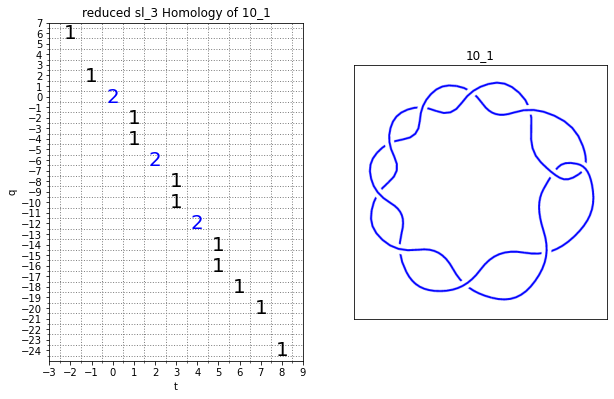

In [53]:
#to get lewark sl3 homology we must replace t by -t by using 'L' as third argument
plot_homology_sl(3,knot,'Lbar')

In [43]:
homology_sl(3,knot,'L')==sl3_link_homology(knot)

True

In [55]:
#originally gave false because 'L' conventions were not right. They seemed right because a lot of the
#data was invariant under q<->-q (why is this?)
all(
    homology_sl(3,knot,'L')==sl3_link_homology(knot) 
    for knot in homfly_data.keys()
)

False

In [56]:
#if we allow for both possibilities (q<->-q or t<->-t) then all homologies match up... does mirror explain this? 
all(
    (
        homology_sl(3,knot,'L')==sl3_link_homology(knot) 
     or 
        homology_sl(3,knot,'Lbar')==sl3_link_homology(knot)
    ) 
    for knot in homfly_data.keys()
)

True

In [45]:
same_sl3_L=[knot for knot in homfly_data.keys() if (homology_sl(3,knot,'L')==sl3_link_homology(knot))]
len(same_sl3)

163

In [57]:
same_sl3_Lbar=[knot for knot in homfly_data.keys() if (homology_sl(3,knot,'Lbar')==sl3_link_homology(knot))]
len(same_sl3_Lbar)

556

In [59]:
#these knots have special symmetry (explanation?) 
same_sl3_both=[
    knot for knot in homfly_data.keys() if 
    (
        homology_sl(3,knot,'L')==sl3_link_homology(knot)
        and
        homology_sl(3,knot,'Lbar')==sl3_link_homology(knot)
    )
]
len(same_sl3_both)

24

In [ ]:
#What is going on here?? To get from DGR to Lewark, it seems we need to either switch t with -t or q with -q
#could it be the issue that in the datasets, one is using 10_1 and one is using -10_1 (the mirror)?

In [ ]:
#can now get reduced sl_2 homology
plot_homology_sl(2,knot,'L')

In [ ]:
#to go from homfly to khovanov, look along the knight move diagonals (q->q+4, a->a+2)
knot='8_19'
plot_homology(knot)
plot_homology_2D(knot,'DGR',True,True, 'qa')

In [ ]:
#to go from homfly to khovanov, look along the knight move diagonals (q->q+4, a->a+2)
knot='10_10'
plot_homology(knot)
plot_homology_2D(knot,'DGR',True,True, 'qa')
plot_homology_sl(2,knot,'DGR')

In [ ]:
#to go from homfly to khovanov, look along the knight move diagonals (q->q+4, a->a+2)
knot='11a_263'
plot_homology(knot)
plot_homology_2D(knot,'DGR',True,True, 'qa')

In [ ]:
def size_of_homology(knot):
    homology=homfly_data[knot]
    size=0
    for key in homology.keys():
        size+=homology[key]
    return size

sizes=[]
for key in non_planar_knots:
    sizes.append([key,size_of_homology(key)])
sizes
max([size[1] for size in sizes])

In [ ]:
#largest homology knot in dataset plotted in 3d (rank 109)
knot='11n_182'
plot_homology(knot)
plot_homology_2D(knot,'DGR',True,True, 'qa')

In [ ]:
# showing 3d plots for some non thin knots
for knot in non_planar_knots[0:10]:
    plot_homology(knot)

In [ ]:
#compares sl2 homology to sl3 homology for all knots in dataset
for knot in homfly_data.keys():
    if planar_support_alt(homfly_data[knot])==1:
        plot_homology_2D(knot,'NS',True,True,'qa')
        plot_homology_sl(2,knot,'L')
        plot_homology_sl(3,knot,'L')
        plot_homology_sl(4,knot,'L')
        plot_homology_sl(5,knot,'L')

In [ ]:
plot_sl3('4_1')